#  <center> <font style="color:rgb(100,109,254)"> Object Detection </font> </center>

In this notebook we'll use another pretrained deep neural network, we'll be doing Object detection this time, meaning not only do we get the names of the detected classes but we'll also get the bounding box locations of those objects.

**So here's the difference**

**```Classification:```** Input(image) = *Output( Class_Label, Confidence_Score )*

**```Detection:```** Input(image) = *Output( Class_label, Confidence_Score, Coordinates_of_Object)*


The detector we'll be using is a MobileNet based Single Shot Multibox detector (SSD).

Here's how you implement Object Detection in Deep learning, there are two parts to it, just like in the classical Vision pipeline you take a classifier and classify patches of images with a sliding window, you can do the same thing with deep learning but it would've been extremely slow. So to solve this problem this problem over the years people have come up with different Object Detection Architectures and they all have evolved and improved over time. So now the norm is that to perform detection you first take a base Convolutional model (a Classification Model):

-  **GoogleLeNet**
-  **SqueezeNet**
-  **ResNet**
-  **MobileNet**

And you plug it in a Detection Framework, these can be:

- **RCNN family i.e. fast RCNN, faster RCNN etc.**
- **SSD (Really fast)**.


Ofcourse this is not an exhaustive list, but this gives you a good Idea how a detection problem in deep learning is structured.


**Note:** When you combine the base model to detection architecture some changes are made to the original base model so its compatible to the detection architecture.

There are also other type of detectors like **YOLO (You only look once)**  variations which don't use a base network and have a different architecture design. We will look at this network in the next notebook.

In this notebook for our detection task we'll be using One of the fastest base models i.e. a MobileNet (It differs from common CNNs as it uses Depth wise separable convolutions), this particular base model has an architecture that dramatically reduces the number of parameters in the networks while still maintaining a decent accuracy.

Our Detection Architecture will be a Single Shot multibox Detector or an SSD. This is also one of the fastest detection Architecture.

These two combine together will make a really fast Object Detection Pipeline. Our Models have been trained in Tensorflow and we'll be loading them much like the same way we did our classifier.

In [13]:
# Importing Required Libraries 
import numpy as np
import time
import cv2
from tkinter import filedialog
from tkinter import Tk
import matplotlib.pyplot as plt
import random
import os

## <font style="color:rgb(134,19,348)"> Loading class labels </font>
We'll start by loading class labels, this detection network is trained on COCO dataset (Common Objects in Context) which has 80-90 classes. Then it has been fine tuned on Pascal VOC dataset which has 20 classes. We're defining these classes.

In [15]:
# Extract the Classes.
CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
"bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
"dog", "horse", "motorbike", "person", "pottedplant", "sheep",
"sofa", "train", "tvmonitor"]

# Total number of Classes - background class
print('Total Number of classes are: {} \n'.format(len(CLASSES)-1))
      
# See the classes.      
print(CLASSES)

Total Number of classes are: 20 

['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


**We'll be drawing each class with a particular colored box, so we'll create a list of unique colors**

In [16]:
# Randomize with same pattern each time.
np.random.seed(50)

# Create the random list of colors of required size.
COLORS = np.random.uniform(0, 255, size=(len(CLASSES),3))

## <font style="color:rgb(134,19,348)">  Initializing the DNN Module </font>

[```retval = cv2.dnn.readNetFromTensorflow(model[, config] )```](https://docs.opencv.org/4.2.0/d6/d0f/group__dnn.html#gad820b280978d06773234ba6841e77e8d)

**Params:**

- **`model:`**	Path to Actual frozen model in .pb format.
- **`config`**	Path to the .pbtxt file that contains text graph definition (Model Architecture information) in protobuf format.


In [17]:
# Load the Model Weights.
weights ='Media/M4/Model/MobileNetSSD_deploy.caffemodel'

# Load the googleNet Architecture.
arch= 'Media/M4/Model/MobileNetSSD_deploy.prototxt.txt'

# Initialize the network.
net = cv2.dnn.readNetFromCaffe(arch, weights)

## <font style="color:rgb(134,19,348)"> Read An Image </font>

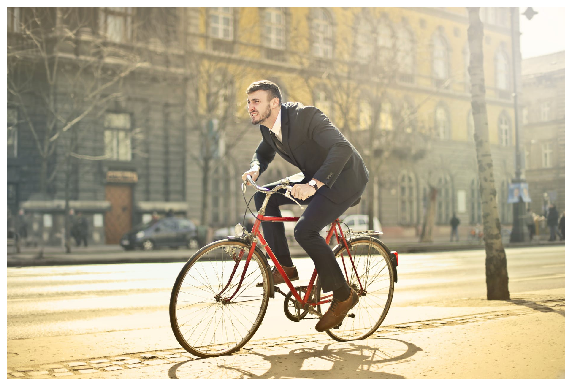

In [18]:
# Load the input image from disk
image = cv2.imread('Media/M4/bicycle.jpeg')

# Display it
plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1])
plt.axis("off");

## <font style="color:rgb(134,19,348)"> Pre-processing the image </font>

 [```blob = cv2.dnn.blobFromImage(image[, scalefactor[, size[, mean[, swapRB[, crop]]]]])```]( https://docs.opencv.org/4.2.0/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7)

**Params:**

- **`Image`**  Input image.
- **`Scalefactor`**  Used to normalize the image. This value is multiplied by the image, value of 1 means no scaling is done.
- **`Size`**  The size to which the image will be resized to, this depends upon the each model. 
- **`Mean`** These are mean R,G,B Channel values from the whole dataset and these are subtracted from the image's R,G,B respectively, this gives illumination invariance to the model.
- **`swapRB`** Boolean flag (false by default) this indicates weather swap first and last channels in 3-channel image is necessary.
- **`crop`** flag which indicates whether image will be cropped after resize or not. If crop is true, input image is resized so one side after resize is equal to corresponding dimension in size and another one is equal or larger. Then, crop from the center is performed. If crop is false, direct resize without cropping and preserving aspect ratio is performed.

So After this function we get a 4d blob, this is what we'll pass to the network.

In [19]:
blob = cv2.dnn.blobFromImage(image, 0.007843,(300, 300), (127.5,127.5,127.5),True)

**Note: Unlike Caffe, Tensorflow models are trained on RGB images so we're swapping RGB channels**

## <font style="color:rgb(134,19,348)"> Input the Blob Image to the Network  </font>
Here you're setting up the blob image as the input to the network.

In [21]:
# Passing the blob as input through the network 
net.setInput(blob)

##  <font style="color:rgb(134,19,348)"> Forward Pass </font>
Pass your processed image through the detector.

In [23]:
%%time
# Return the detections 
detections = net.forward()

Wall time: 101 ms


In [24]:
# Check the shape of the returned Object
print(detections.shape)

(1, 1, 100, 7)


##  <font style="color:rgb(134,19,348)"> Post Processing </font>

Now to get the results of Detection (classes, bounding boxes etc) we need to extract them from the returned `detection` object, so we're going to do some post processing.

**Our detection object is a 4 dimensional matrix**

- ``1st and 2nd dimension is a constant 1 when you're passing a single image through the detector.``

- ``3rd value denotes the number of detections it detects in the given image``

- ``4th represents the properties, basically every class has 7 properties which we discuss further``

In [25]:
print("Number of detections in this image is: {}".format(detections.shape[2]))

Number of detections in this image is: 100


**Of course most of these are weak detections and we will filter them with a threshold**

In [26]:
# Lets see those 7 properties of the first detection
detections[0][0][0]

array([0.        , 2.        , 0.9999907 , 0.29856214, 0.45196623,
       0.69221985, 0.9310797 ], dtype=float32)

**These 7 values are:**

1. **`This is the index of image for a single image its 0`**

2. **`This is the index of the target CLASS`**

3. **`This is the Probability of that CLASS`**

*Remaining 4 values are x1,y1,x2,y2. These are used to draw the bounding box of that CLASS object*

4.  **`x1`**

5.  **`y1`**

6.  **`x2`**

7.  **`y2`**

## <font style="color:rgb(134,19,348)"> Draw the Bounding Boxes </font>
Now that we have understood the structure of our detection object, we'll loop through it and draw each detection with its class name and bounding box if it has enough confidence.

bicycle: 100.00%
person: 99.95%


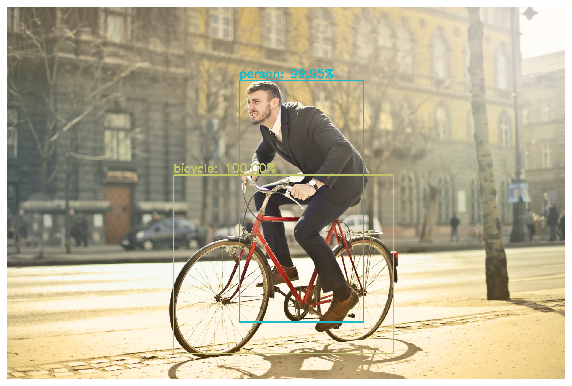

In [27]:
h,w = image.shape[:2]
img_copy = image.copy()

# Objects with confidence less than this are ignored
threshold = 0.5

# Loop over the detections
for i in np.arange(0, detections.shape[2]):
    
    # Extract the confidence probablity associated with the prediction 
    confidence = detections[0, 0, i, 2]

    # Filter Out weak detections
    if confidence > threshold:
        
        # Extracting the index of the class.
        index = int(detections[0, 0, i, 1])
        
        # Extract the (x1,x2,y1,y2) coordinates of the bounding box for each obejct 
        x_1 = int(detections[0, 0, i, 3] * w)
        y_1 = int(detections[0, 0, i, 4] * h)
        x_2 = int(detections[0, 0, i, 5] * w)
        y_2 = int(detections[0, 0, i, 6] * h)

        # Display the target class name and their confidence score.
        label = "{}: {:.2f}%".format(CLASSES[index], confidence * 100)
        
        print(label)
                
        # Draw the rectangle on object w.r.t their cordinates. 
        cv2.rectangle(img_copy, (x_1, y_1), (x_2, y_2), COLORS[index], 4)
        
        # Put the Label of the detected object 
        cv2.putText(img_copy, label, (x_1, y_1-10), cv2.FONT_ITALIC, 1.3, COLORS[index], 3)

# Display Detection
plt.figure(figsize=(10,10))        
plt.imshow(img_copy[:,:,::-1])
plt.axis("off");

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialization Function </font>
This method will be run once and it will initialize the network with the required files.

In [28]:
def init_detection(usegpu = 'None',weights_name = 'MobileNetSSD_deploy.caffemodel', architecture_name = 'MobileNetSSD_deploy.prototxt.txt'):
    
    # Set global variables
    global net, classes,colors
    
    base_path = 'Media/M4/Model'
    
    # Read the Classes
    classes = ["background", "aeroplane", "bicycle", "bird", "boat",
    "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
    "sofa", "train", "tvmonitor"]
    
    weights = os.path.join(base_path, weights_name)
    architecture = os.path.join(base_path, architecture_name)
    
    np.random.seed(50)
    colors = np.random.uniform(100, 255, size=(len(classes),3))
    
    # Intialize the model
    net = cv2.dnn.readNetFromCaffe(architecture,weights)

    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)

## <font style="color:rgb(134,19,348)">  Main Method </font>

In [29]:
def detection(image=[], usercam=False, returndata=False, size=0.7,conf=0.5):
    
    # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
        # If usercam cam is True then take picture from camera
        if usercam:
            cap=cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame=cap.read()
            if ret:
                image= cv2.flip(frame,1)
                cap.release()
            else:
                print('Cant Open Camera')
                sys.exit()
        
        # Otherwise select image from computer using tkinter
        else:
            root = Tk()
            filename =  filedialog.askopenfilename(title = "Select Image")
            root.withdraw()
            image = cv2.imread(filename)

            
    blob = cv2.dnn.blobFromImage(image, 0.007843,(300, 300), (127.5,127.5,127.5),True)
    net.setInput(blob)
    detections = net.forward()
    
    
    # This list will store class names with their confidence scores
    class_data = []

    h,w = image.shape[:2]
    
    # Loop over the detections
    for i in np.arange(0, detections.shape[2]):
    
        # Extract the confidence probablity associated with the prediction 
        confidence = detections[0, 0, i, 2]

        # Filter Out weak detections
        if confidence > conf:
            
            # Extracting the index of the class.
            index = int(detections[0, 0, i, 1])
    
            # Extract the (x1,x2,y1,y2) coordinates of the bounding box for each obejct 
            x_1 = int(detections[0, 0, i, 3] * w)
            y_1 = int(detections[0, 0, i, 4] * h)
            x_2 = int(detections[0, 0, i, 5] * w)
            y_2 = int(detections[0, 0, i, 6] * h)

            # Display the target class name and their confidence score.
            label = "{}: {:.2f}%".format(classes[index], confidence * 100)
            
            class_data.append(((classes[index], confidence)))
                        
            # Draw the rectangle on object w.r.t their cordinates. 
            cv2.rectangle(image, (x_1, y_1), (x_2, y_2), colors[index], 4)

            # Put the Label of the detected object 
            cv2.putText(image, label, (x_1, y_1-10), cv2.FONT_ITALIC, size, colors[index], 2)

    if  returndata:
        return image, class_data
 
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image[:,:,::-1]);plt.axis("off");

#### Initialize the Network

In [30]:
# Iniitalize the method
init_detection()

#### Calling the detector with default args

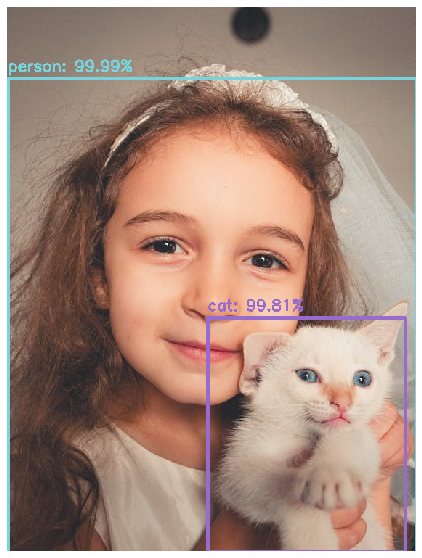

In [31]:
image = cv2.imread("Media/M4/girl_cat.jpeg")
detection(image)

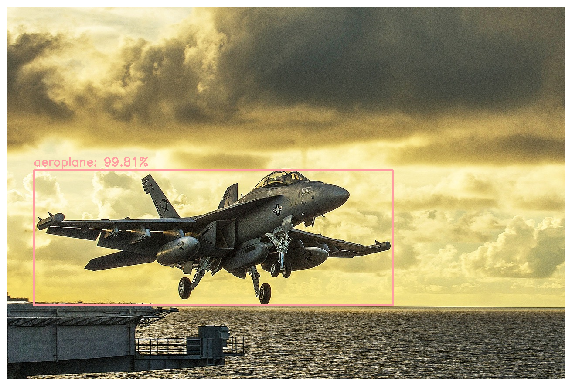

In [32]:
image = cv2.imread("Media/M4/jet.jpg")
detection(image,size=0.9)

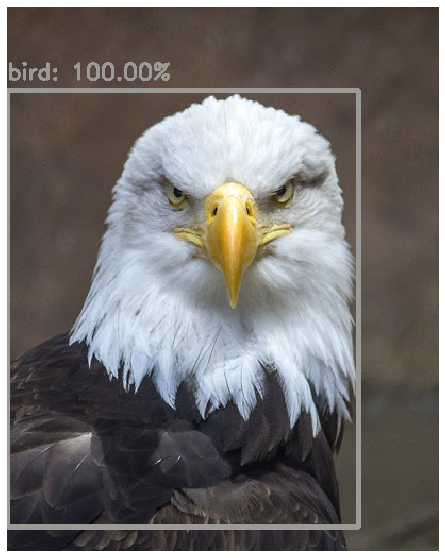

In [33]:
image = cv2.imread("Media/M4/eagle1.jpg")
detection(image)

#### Taking the Image from the camera

In [ ]:
detection(usercam=True)

#### Using the Data Returned

In [34]:
image,data= detection(returndata=True)
for my_detection in data:
    print('Label {} Confidence: {:.2f}% Co-ordinates: {}'.format(my_detection[0],my_detection[1],my_detection[2:]))

Label cat Confidence: 0.99% Co-ordinates: ()


**You can run detection on an image you already read**

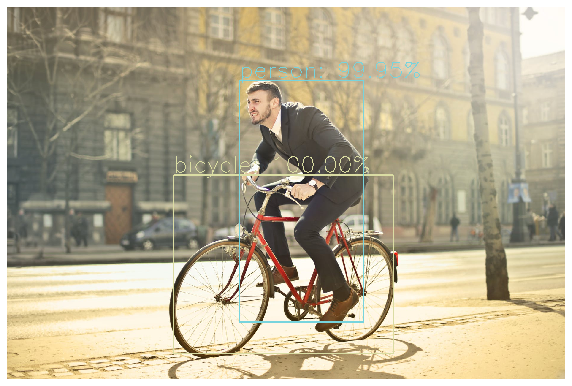

In [35]:
image = cv2.imread('Media/M4/bicycle.jpeg')
detection(image=image,size=2.5)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>

**CPU Time**

In [ ]:
init_detection()

In [ ]:
%%time
image, result= detection(image = image, returndata=True)

**Intel GPU**

In [ ]:
init_detection(usegpu = 'opencl')

In [ ]:
%%time
image, result= detection(image = image, returndata=True)

**NVIDIA GPU**

In [ ]:
init_detection(usegpu = 'cuda')

In [ ]:
%%time
image, result= detection(image = image, returndata=True)

## <font style="color:rgb(134,19,348)"> Real time object detection </font>

In [ ]:
fps=0
init_detection()
cap=cv2.VideoCapture(0)

while(True):    
    
    start_time = time.time()
    ret,frame=cap.read() 
    image=cv2.flip(frame,1)
    
    image,_= detection(image,returndata=True)
    
    cv2.putText(image, 'FPS: {:.2f}'.format(fps), (400, 20), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 20, 55), 2)
    
    cv2.imshow("Image",image)
    
    k = cv2.waitKey(1)
    fps= (1.0 / (time.time() - start_time))
    
    if k == ord('q'):
        break
cap.release() 
cv2.destroyAllWindows() 